# HW05: Decision Tree Regression
## Hamza Dehidi KU 0077989
### December 02, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygraphviz as pgv


## Importing Data

In [2]:
# read data into memory
data_set = np.genfromtxt("hw05_data_set.csv", skip_header=1,delimiter = ",")
X = data_set[:,0]
y = data_set[:,1].astype(int)

# x and y training values
X_train = X[:150]
y_train = y[:150]


# x and y test values
X_test = X[150:]
y_test = y[150:]

In [3]:
# get numbers of train
N_train = len(y_train)


## Tree Inference

In [4]:
class decision_tree:
    
    def __init__(self):
        
        # create necessary data structures
        self.__node_indices = {}
        self.__is_terminal = {}
        self.__need_split = {}

        self.__node_features = {}
        self.__node_splits = {}
        self.__node_values = {}
        
    # learning algorithm
    def predict(self,x_values,p = 25):

        ''' 
        x_values are the x coordinate 
        p is the pruning factor the default value = 25, ex. node which has less than 25 will be considered as terminal

        This method returns the preidected y values on the provided x values'''

        # put all training instances into the root node
        self.__node_indices[1] = np.array(range(N_train))
        self.__is_terminal[1] = False
        self.__need_split[1] = True

        while True:

            # find nodes that need splitting
            split_nodes = [key for key, value in self.__need_split.items() if value == True]

            # check whether we reach all terminal nodes
            if len(split_nodes) == 0:
                break

            # find best split positions for all nodes
            for split_node in split_nodes:
                data_indices = self.__node_indices[split_node]
                self.__need_split[split_node] = False
                self.__node_values[split_node] = np.mean(y_train[data_indices])

                #pre-prunining condition
                if len(data_indices) <= p:
                    self.__is_terminal[split_node] = True

                else:
                    self.__is_terminal[split_node] = False

                    #pre-prunining condition
                    unique_values = np.sort(np.unique(X_train[data_indices]))

                    # getting the split position, the middle between each two unique points 
                    split_positions = (unique_values[1:len(unique_values)] + unique_values[0:(len(unique_values) - 1)]) / 2

                    # split scores, array to store all the error scores of all the split positions
                    split_scores = np.repeat(0.0, len(split_positions))

                    for sp_pos in range(len(split_positions)):
                        left_indices = data_indices[X_train[data_indices] > split_positions[sp_pos]]
                        #print('left_indices =',left_indices)
                        right_indices = data_indices[X_train[data_indices] < split_positions[sp_pos]]
                        #print('right_indices =',right_indices)

                        left_g_m = np.mean(y_train[left_indices]) # the mean of y_values of the the instances reached the left node
                        right_g_m = np.mean(y_train[right_indices]) # the mean of y_values of the the instances reached the right node

                        # split scores, array stores all the error scores of all the split positions
                        split_scores[sp_pos] = (1/len(data_indices))*(np.sum((y_train[left_indices] - left_g_m )**2) 
                                                                      + np.sum((y_train[right_indices] - right_g_m )**2))

                    # to get the best score between all the split scores, which is the lowest error
                    best_score = np.min(split_scores)

                    # to store the x_coordinate which gave us the lowest score
                    best_split = split_positions[np.argmin(split_scores)]

                    # to store best splits in a dictionary 
                    self.__node_splits[split_node] = best_split

                    # create left node using the selected split
                    left_indices = data_indices[X_train[data_indices] >= best_split]
                    #print('left_indices',left_indices)
                    self.__node_indices[2 * split_node] = left_indices
                    self.__is_terminal[2 * split_node] = False
                    self.__need_split[2 * split_node] = True

                    # create right node using the selected split
                    right_indices = data_indices[X_train[data_indices] <= best_split]
                    #print('right_indices',right_indices)
                    self.__node_indices[2 * split_node + 1] = right_indices
                    self.__is_terminal[2 * split_node + 1] = False
                    self.__need_split[2 * split_node + 1] = True

        # to get the predicted y values of the x_coordinates
        y_predicted = np.repeat(0.0, len(x_values))
        for i in range(len(x_values)):
            index = 1
            while True:
                if self.__is_terminal[index] == True:
                    y_predicted[i] = self.__node_values[index]
                    break
                else:
                    if x_values[i] > self.__node_splits[index]:
                        index = index * 2
                    else:
                        index = index * 2 + 1

        return y_predicted
    
    
    def isTerminal(self):
        return self.__is_terminal
    
    def getSplits(self):
        return self.__node_splits
    
    def getTerminalNodesValues(self):
        return self.__node_values
    

In [5]:
training_tree = decision_tree()

In [6]:
training_y_pridected = training_tree.predict(X_train,p=25)

In [7]:
splits = training_tree.getSplits()

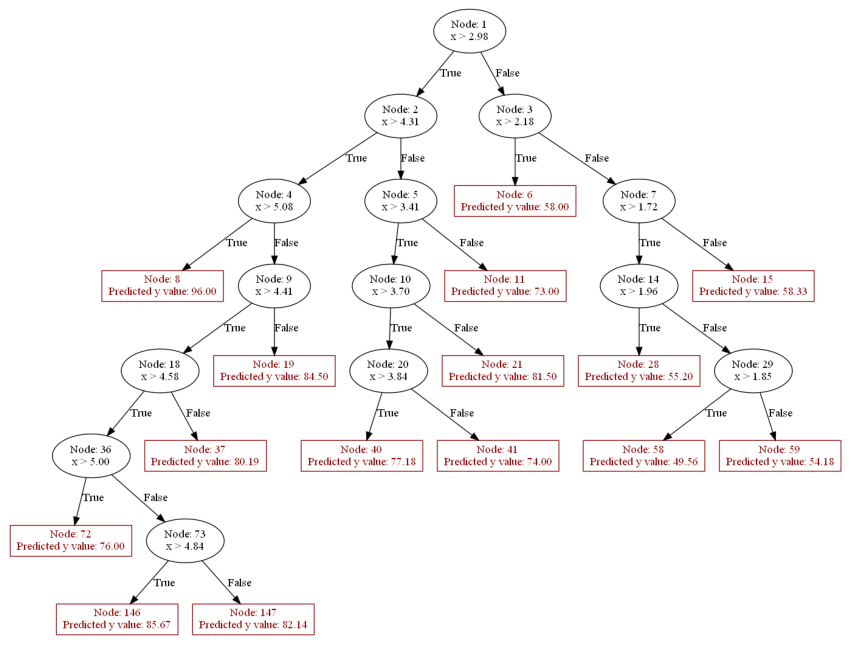

In [8]:
def draw_tree():

    T = pgv.AGraph(directed = True, strict = True, rankdir = "UB")

    for key, value in training_tree.isTerminal().items():
        if training_tree.isTerminal()[key] == False:
            T.add_node(key, shape = "ellipse", color = "black", 
                       label = "Node: {:d}\nx > {:.2f}".format(key,splits[key]))                                                                                  
                                                                                    
        else:
            T.add_node(key, shape = "rectangle", 
                       color = "darkred",
                       fontcolor = "darkred",
                       label = "Node: {:d}\nPredicted y value: {:.2f}\n".format(key,training_tree.getTerminalNodesValues()[key]))
                                                                                     

    for key, value in training_tree.isTerminal().items():
        if key > 1:
            if key % 2 == 0:
                T.add_edge(key // 2, key, label = "True", color = "black")
            else:
                T.add_edge(key // 2, key, label = "False", color = "black")

    T.layout("dot")
    T.draw("decision_tree.png")

draw_tree()
#import matplotlib.pyplot as plt
plt.figure(figsize = (15, 24))
plt.axis("off")
plt.imshow(plt.imread("decision_tree.png"))
plt.show()

## Rule Extraction

In [9]:
# extract rules

terminal_nodes = [key for key, value in training_tree.isTerminal().items() if value == True]
for terminal_node in terminal_nodes:
    index = terminal_node
    rules = np.array([])
    while index > 1:
        parent = np.floor(index / 2)
        if index % 2 == 0:
            # if node is left child of its parent
            rules = np.append(rules, "x > {:.2f}".format(splits[parent]))
        else:
            # if node is right child of its parent
            rules = np.append(rules, "x <= {:.2f}".format(splits[parent]))
        index = parent
    rules = np.flip(rules)
    print("{} ---> [y = {:.2f}]".format(rules, training_tree.getTerminalNodesValues()[terminal_node]))

['x <= 2.98' 'x > 2.18'] ---> [y = 58.00]
['x > 2.98' 'x > 4.31' 'x > 5.08'] ---> [y = 96.00]
['x > 2.98' 'x <= 4.31' 'x <= 3.41'] ---> [y = 73.00]
['x <= 2.98' 'x <= 2.18' 'x <= 1.72'] ---> [y = 58.33]
['x > 2.98' 'x > 4.31' 'x <= 5.08' 'x <= 4.41'] ---> [y = 84.50]
['x > 2.98' 'x <= 4.31' 'x > 3.41' 'x <= 3.70'] ---> [y = 81.50]
['x <= 2.98' 'x <= 2.18' 'x > 1.72' 'x > 1.96'] ---> [y = 55.20]
['x > 2.98' 'x > 4.31' 'x <= 5.08' 'x > 4.41' 'x <= 4.58'] ---> [y = 80.19]
['x > 2.98' 'x <= 4.31' 'x > 3.41' 'x > 3.70' 'x > 3.84'] ---> [y = 77.18]
['x > 2.98' 'x <= 4.31' 'x > 3.41' 'x > 3.70' 'x <= 3.84'] ---> [y = 74.00]
['x <= 2.98' 'x <= 2.18' 'x > 1.72' 'x <= 1.96' 'x > 1.85'] ---> [y = 49.56]
['x <= 2.98' 'x <= 2.18' 'x > 1.72' 'x <= 1.96' 'x <= 1.85'] ---> [y = 54.18]
['x > 2.98' 'x > 4.31' 'x <= 5.08' 'x > 4.41' 'x > 4.58' 'x > 5.00'] ---> [y = 76.00]
['x > 2.98' 'x > 4.31' 'x <= 5.08' 'x > 4.41' 'x > 4.58' 'x <= 5.00'
 'x > 4.84'] ---> [y = 85.67]
['x > 2.98' 'x > 4.31' 'x <= 5.08' 

## Training Performance

In [10]:
point_colors = np.array(["red", "blue"])
minimum_value = +1.5
maximum_value = +5.2
p =25  #if the node has less than p, it will be converted as terminal node 
data_interval = np.linspace(minimum_value, maximum_value, 741)


In [11]:
data_interval_tree = decision_tree()
data_interval_predicts = data_interval_tree.predict(data_interval)

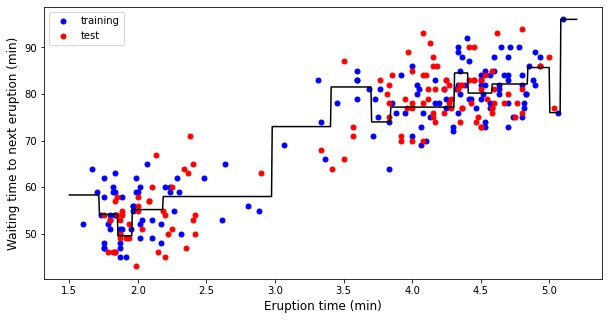

In [12]:
plt.figure(figsize = (10, 5))
plt.plot(X_train,y_train, "b.", markersize = 10,label ='training')
plt.plot(X_test,y_test, "r.", markersize = 10,label ='test')
plt.legend()
plt.xlabel('Eruption time (min)', fontsize=12)
plt.ylabel('Waiting time to next eruption (min)', fontsize=12)

plt.plot(data_interval, data_interval_predicts, "k-")
plt.show()

#### Calculating the root mean squared error

$\sqrt{\dfrac{\sum \limits_{i = 1}^{N_{test}} ({y_{i} - \hat{y}_{i}})^2}{N_{test}}}$

In [13]:
def RMSE(x_values,true_y_values,prun =25):
    tree = decision_tree()
    predicted_y_values = tree.predict(x_values,prun)

    RMSE = np.sqrt(np.mean(np.square(true_y_values - predicted_y_values)))
    return RMSE

In [14]:
print(f'RMSE on training set is {RMSE(X_train,y_train)} when p is {p}')

RMSE on training set is 4.541214189194451 when p is 25


In [15]:
print(f'RMSE on test set is {RMSE(X_test,y_test)} when p is {p}')

RMSE on test set is 6.454083413352087 when p is 25


In [16]:
p_sizes = np.arange(5,55,5)
RMSE_train = [RMSE(X_train,y_train,p) for p in p_sizes]
RMSE_test = [RMSE(X_test,y_test,p) for p in p_sizes]

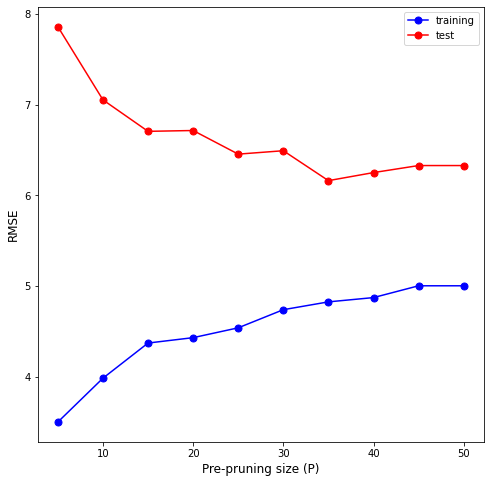

In [17]:
plt.figure(figsize = (8, 8))
plt.plot(p_sizes,RMSE_train, "-bo",markersize = 7,label ='training')
plt.plot(p_sizes,RMSE_test, "-ro", markersize = 7,label ='test')
plt.legend()
plt.xlabel('Pre-pruning size (P)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

plt.show()